In [47]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from prettytable import PrettyTable

# Initialize the NLTK WordNet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# List of custom words to be excluded from TF-IDF analysis
custom_exclude_words = ['iphone', 'im', 'phone', 'go', 'lol', 'thats', 'apple', 
                       'cant', 'etc', '14', 'pro', 'ive', 'dont', 'use', 'got', 'look', 'really'
                        'used', 'know', 'make', 'max', 'day', 'time', 'new', 'month', 'think', 'people', 'thanks', 'year', 
                       'good', 'nice', 'feel', 'thing', 'great', 'life', '100', 'need', '13', 'way', 'love', 'better', 'yeah',
                       'used', '15', 'like', 'really', 'work', 'want', 'using', 'beautiful', '12', 'raw', 'didnt', 'doesnt',
                       'yes', 'youre', 'thank', 'best', 'lot']

def extract_sentences_with_term(text, term):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    sentences_with_term = [sentence for sentence in sentences if term.lower() in sentence.lower()]
    return sentences_with_term

def lemmatize_text(text):
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split()])

with open('iphone14pro_CD.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract titles, self_text, comments, and replies from each post
documents = []
for post in data["posts"]:  # Access the "posts" key in the JSON structure
    # Check if "comments" key exists and is a list
    if "comments" in post and isinstance(post["comments"], list):
        comments_body = [comment["body"] for comment in post["comments"]]
        
        # Check if "replies" key exists in each comment and is a list
        replies_body = [
            reply["body"]
            for comment in post["comments"]
            if "replies" in comment and isinstance(comment["replies"], list)
            for reply in comment["replies"]
        ]
        
        # Combine title, self_text, comments, and replies
        document = post["title"] + " " + post["self_text"] + " ".join(comments_body + replies_body)
        documents.append(lemmatize_text(document))
    else:
        # If "comments" key is missing or not a list, use only title and self_text
        document = post["title"] + " " + post["self_text"]
        documents.append(lemmatize_text(document))

# Get the default English stop words
english_stop_words = TfidfVectorizer(stop_words='english').get_stop_words()

# Combine default English stop words with custom words
exclude_words = list(set(english_stop_words).union(set(custom_exclude_words)))

# Create a TfidfVectorizer with combined stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=exclude_words)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Optional: Convert the TF-IDF matrix to a dense array for easier handling
dense_tfidf_matrix = tfidf_matrix.toarray()

# Dictionary to store TF-IDF scores for each term
term_tfidf_dict = dict(zip(feature_names, np.sum(dense_tfidf_matrix, axis=0)))

# Sort terms based on their TF-IDF scores in descending order
sorted_terms = sorted(term_tfidf_dict.items(), key=lambda x: x[1], reverse=True)

# Extract top 20 terms
top_n = 20
top_terms = [term[0] for term in sorted_terms[:top_n]]

# Dictionary to store mean sentiment scores for each term
term_sentiments = {}

# Create a table to print TF-IDF terms, TF-IDF scores, and mean sentiment scores
table = PrettyTable()
table.field_names = ["TF-IDF Term", "TF-IDF Score", "Mean Sentiment Score"]

# Iterate through each term and calculate mean sentiment
for term in top_terms:
    # Use the original term for printing, but use the lemmatized version for sentiment analysis
    original_term = term
    term = lemmatize_text(term)

    sentences_with_term = []
    for post in data["posts"]:  # Access the "posts" key in the JSON structure
        combined_text = post["title"] + " " + post["self_text"]
        
        # Include comments and replies for sentiment analysis
        if "comments" in post and isinstance(post["comments"], list):
            combined_text += " ".join(comment["body"] for comment in post["comments"])
            
            for comment in post["comments"]:
                if "replies" in comment and isinstance(comment["replies"], list):
                    combined_text += " ".join(reply["body"] for reply in comment["replies"])

        sentences_with_term.extend(extract_sentences_with_term(combined_text, term))

    sentiment_scores = [TextBlob(sentence).sentiment.polarity for sentence in sentences_with_term]
    if sentiment_scores:  # Check if sentiment_scores is not empty
        mean_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    else:
        mean_sentiment = None

    tfidf_score = term_tfidf_dict[original_term]

    term_sentiments[original_term] = mean_sentiment
    table.add_row([original_term, tfidf_score, mean_sentiment])

# Print the table
print("Top 20 TF-IDF Terms, Their TF-IDF Scores, and Mean Sentiment Scores:")
print(table)


Top 20 TF-IDF Terms, Their TF-IDF Scores, and Mean Sentiment Scores:
+-------------+--------------------+----------------------+
| TF-IDF Term |    TF-IDF Score    | Mean Sentiment Score |
+-------------+--------------------+----------------------+
|   battery   | 24.805519860666834 | 0.11803054172063986  |
|     case    | 13.607571285076508 |  0.1276507062319148  |
|    photo    | 11.418357082011902 | 0.21122874790926405  |
|    camera   | 9.628694013345555  |  0.1765066214821716  |
|     shot    | 9.614253847749955  |  0.2148374956419035  |
|    charge   | 7.482576202406571  | 0.10948033318512468  |
|      io     | 6.364491242783627  | 0.15417300552420105  |
|    issue    | 5.967300370262813  | 0.11353413706970282  |
|    health   | 5.698429892552384  | 0.10333272203375715  |
|    screen   | 5.658617075381463  | 0.13088219642880752  |
|   charging  | 5.6531185168023805 | 0.10450015257884696  |
|   upgrade   | 5.100410795242185  | 0.12710781038622046  |
|   picture   |  5.039987074139

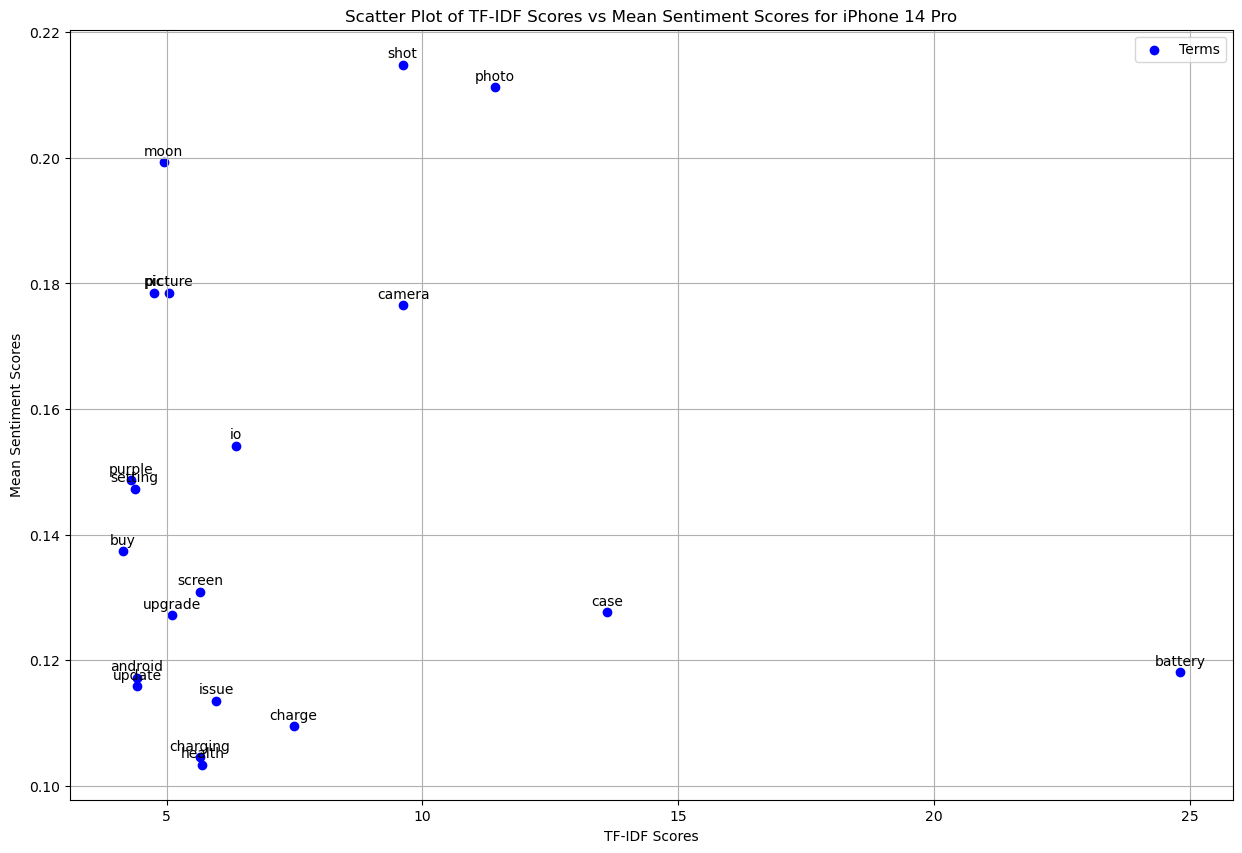

In [57]:
import matplotlib.pyplot as plt

# Extract tfidf_scores and sentiment_scores from term_tfidf_dict and term_sentiments
tfidf_scores = [term_tfidf_dict[term] for term in top_terms]
sentiment_scores = [term_sentiments[term] for term in top_terms]

# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(tfidf_scores, sentiment_scores, c='blue', label='Terms')
plt.title('Scatter Plot of TF-IDF Scores vs Mean Sentiment Scores for iPhone 14 Pro')
plt.xlabel('TF-IDF Scores')
plt.ylabel('Mean Sentiment Scores')

# Annotate each point with the term name
for i, term_name in enumerate(top_terms):
    plt.annotate(term_name, (tfidf_scores[i], sentiment_scores[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.legend()
plt.grid(True)
plt.show()


In [58]:
from sklearn.decomposition import LatentDirichletAllocation

# Prepare the data for LDA
lda_vectorizer = TfidfVectorizer(stop_words=exclude_words)
lda_matrix = lda_vectorizer.fit_transform(documents)

# Fit LDA model
num_topics = 2  
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(lda_matrix)

# Display the top terms for each topic
top_topic_terms = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_terms_idx = topic.argsort()[:-10 - 1:-1]
    top_terms_values = [feature_names[i] for i in top_terms_idx]
    top_topic_terms.append(top_terms_values)

# Print the top terms for each topic
for i, terms in enumerate(top_topic_terms):
    print(f"\nTopic {i + 1}: {', '.join(terms)}")




Topic 1: sunset, unedited, budapart, starling, kayak, snowing, frontier, clownface, snapseed, terrier

Topic 2: battery, case, photo, camera, shot, charge, io, issue, health, screen


In [59]:
import numpy as np



# Extract terms common to both LDA and TF-IDF
common_terms = set(top_terms) & set(term_tfidf_dict.keys())

# Create arrays to store TF-IDF scores and LDA topic weights for common terms
tfidf_scores = np.array([term_tfidf_dict[term] for term in common_terms])
lda_weights = np.zeros((len(common_terms), num_topics))

# Populate the LDA weights array
for i, term in enumerate(common_terms):
    for topic_idx, topic_terms in enumerate(top_topic_terms):
        if term in topic_terms:
            lda_weights[i, topic_idx] = 1  # Assign a weight of 1 if the term is present in the topic

# Calculate covariance matrix
covariance_matrix = np.cov(tfidf_scores, lda_weights, rowvar=False)

# Extract the covariance between TF-IDF scores and each LDA topic
covariance_tfidf_lda = covariance_matrix[0, 1:]

# Print the covariance values
print("\nCovariance between TF-IDF and LDA:")
for topic_idx, cov_value in enumerate(covariance_tfidf_lda):
    print(f"Topic {topic_idx + 1}: {cov_value}")



Covariance between TF-IDF and LDA:
Topic 1: 0.0
Topic 2: 1.3969219428687143


In [60]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Convert the documents to a format suitable for Gensim
tokenized_documents = [doc.split() for doc in documents]
id2word = Dictionary(tokenized_documents)
corpus = [id2word.doc2bow(text) for text in tokenized_documents]

# Fit Gensim LDA model
lda_model_gensim = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)

# Calculate coherence score
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nTopic Coherence Score: {coherence_lda}')



Topic Coherence Score: 0.2676558026347846


### For Iphone 15 

In [61]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from prettytable import PrettyTable

# Initialize the NLTK WordNet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# List of custom words to be excluded from TF-IDF analysis
custom_exclude_words = ['iphone', 'im', 'phone', 'go', 'lol', 'thats', 'apple', 
                       'cant', 'etc', '14', 'pro', 'ive', 'dont', 'use', 'got', 'look', 'really'
                        'used', 'know', 'make', 'max', 'day', 'time', 'new', 'month', 'think', 'people', 'thanks', 'year', 
                       'good', 'nice', 'feel', 'thing', 'great', 'life', '100', 'need', '13', 'way', 'love', 'better', 'yeah',
                       'used', '15', 'like', 'really', 'work', 'want', 'using', 'beautiful', '12', 'raw', 'didnt', 'doesnt',
                       'yes', 'youre', 'thank', 'best', 'lot']

def extract_sentences_with_term(text, term):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    sentences_with_term = [sentence for sentence in sentences if term.lower() in sentence.lower()]
    return sentences_with_term

def lemmatize_text(text):
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split()])

with open('iphone15pro_CD.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract titles, self_text, comments, and replies from each post
documents = []
for post in data["posts"]:  # Access the "posts" key in the JSON structure
    # Check if "comments" key exists and is a list
    if "comments" in post and isinstance(post["comments"], list):
        comments_body = [comment["body"] for comment in post["comments"]]
        
        # Check if "replies" key exists in each comment and is a list
        replies_body = [
            reply["body"]
            for comment in post["comments"]
            if "replies" in comment and isinstance(comment["replies"], list)
            for reply in comment["replies"]
        ]
        
        # Combine title, self_text, comments, and replies
        document = post["title"] + " " + post["self_text"] + " ".join(comments_body + replies_body)
        documents.append(lemmatize_text(document))
    else:
        # If "comments" key is missing or not a list, use only title and self_text
        document = post["title"] + " " + post["self_text"]
        documents.append(lemmatize_text(document))

# Get the default English stop words
english_stop_words = TfidfVectorizer(stop_words='english').get_stop_words()

# Combine default English stop words with custom words
exclude_words = list(set(english_stop_words).union(set(custom_exclude_words)))

# Create a TfidfVectorizer with combined stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=exclude_words)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Optional: Convert the TF-IDF matrix to a dense array for easier handling
dense_tfidf_matrix = tfidf_matrix.toarray()

# Dictionary to store TF-IDF scores for each term
term_tfidf_dict = dict(zip(feature_names, np.sum(dense_tfidf_matrix, axis=0)))

# Sort terms based on their TF-IDF scores in descending order
sorted_terms = sorted(term_tfidf_dict.items(), key=lambda x: x[1], reverse=True)

# Extract top 20 terms
top_n = 20
top_terms = [term[0] for term in sorted_terms[:top_n]]

# Dictionary to store mean sentiment scores for each term
term_sentiments = {}

# Create a table to print TF-IDF terms, TF-IDF scores, and mean sentiment scores
table = PrettyTable()
table.field_names = ["TF-IDF Term", "TF-IDF Score", "Mean Sentiment Score"]

# Iterate through each term and calculate mean sentiment
for term in top_terms:
    # Use the original term for printing, but use the lemmatized version for sentiment analysis
    original_term = term
    term = lemmatize_text(term)

    sentences_with_term = []
    for post in data["posts"]:  # Access the "posts" key in the JSON structure
        combined_text = post["title"] + " " + post["self_text"]
        
        # Include comments and replies for sentiment analysis
        if "comments" in post and isinstance(post["comments"], list):
            combined_text += " ".join(comment["body"] for comment in post["comments"])
            
            for comment in post["comments"]:
                if "replies" in comment and isinstance(comment["replies"], list):
                    combined_text += " ".join(reply["body"] for reply in comment["replies"])

        sentences_with_term.extend(extract_sentences_with_term(combined_text, term))

    sentiment_scores = [TextBlob(sentence).sentiment.polarity for sentence in sentences_with_term]
    if sentiment_scores:  # Check if sentiment_scores is not empty
        mean_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    else:
        mean_sentiment = None

    tfidf_score = term_tfidf_dict[original_term]

    term_sentiments[original_term] = mean_sentiment
    table.add_row([original_term, tfidf_score, mean_sentiment])

# Print the table
print("Top 20 TF-IDF Terms, Their TF-IDF Scores, and Mean Sentiment Scores:")
print(table)


Top 20 TF-IDF Terms, Their TF-IDF Scores, and Mean Sentiment Scores:
+-------------+--------------------+----------------------+
| TF-IDF Term |    TF-IDF Score    | Mean Sentiment Score |
+-------------+--------------------+----------------------+
|     case    |  88.1858034945989  | 0.15759042485507224  |
|   battery   | 52.32339210138173  |  0.1589259836794362  |
|    camera   | 37.53805701139811  | 0.18381142744119175  |
|     blue    |  35.6496087298534  | 0.16167433603632408  |
|    screen   | 30.791108978704084 |  0.1563423557856757  |
|   titanium  | 30.453787165873035 |  0.1655422346228925  |
|    color    | 29.080119455954435 |  0.1718320657975087  |
|    black    |  27.9223599762852  | 0.15502801707317193  |
|    photo    | 27.45465214520807  |  0.1858613190958774  |
|   natural   | 26.112124332776446 | 0.16437541913503656  |
|    white    | 25.279894675452343 |  0.1648560056698694  |
|   upgrade   | 23.474766676657584 | 0.16441926577244392  |
|     shot    | 19.541139416718

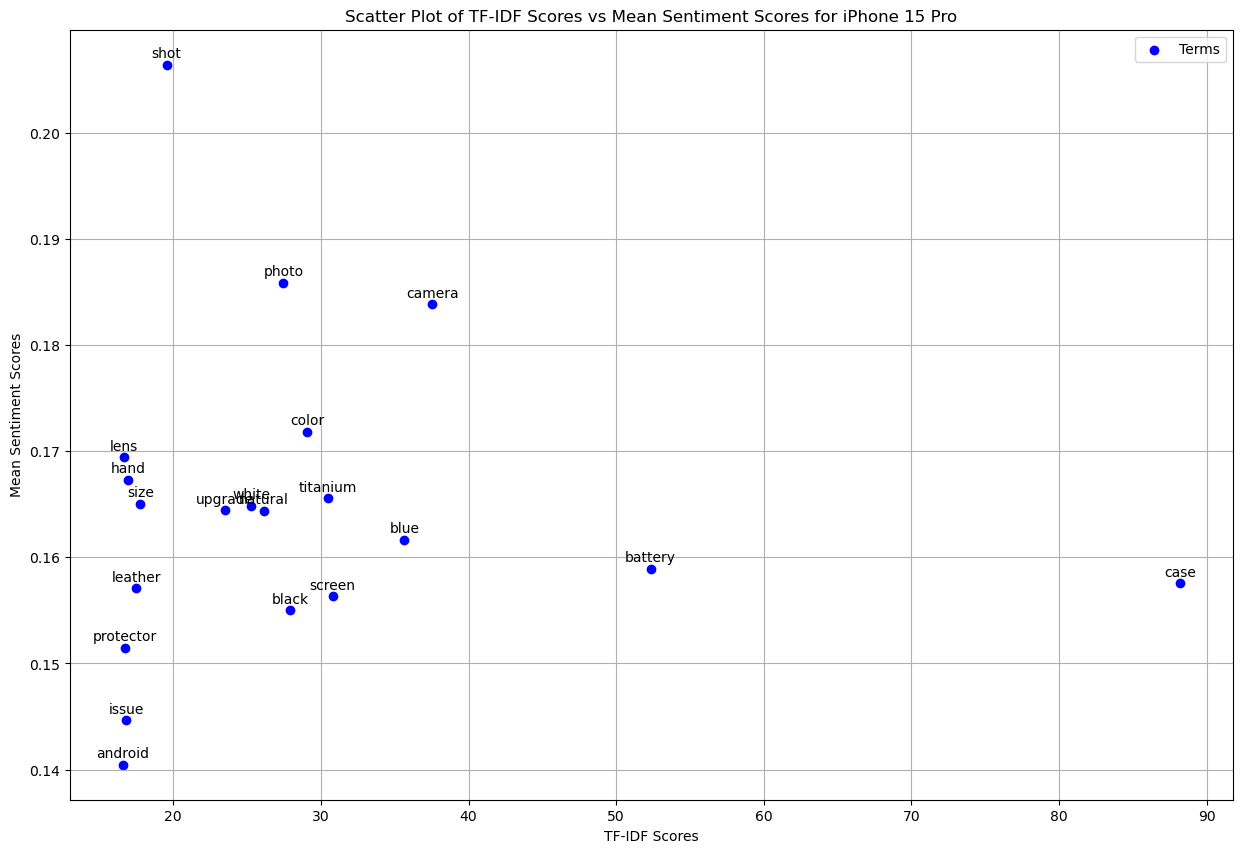

In [62]:
import matplotlib.pyplot as plt

# Extract tfidf_scores and sentiment_scores from term_tfidf_dict and term_sentiments
tfidf_scores = [term_tfidf_dict[term] for term in top_terms]
sentiment_scores = [term_sentiments[term] for term in top_terms]

# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(tfidf_scores, sentiment_scores, c='blue', label='Terms')
plt.title('Scatter Plot of TF-IDF Scores vs Mean Sentiment Scores for iPhone 15 Pro')
plt.xlabel('TF-IDF Scores')
plt.ylabel('Mean Sentiment Scores')

# Annotate each point with the term name
for i, term_name in enumerate(top_terms):
    plt.annotate(term_name, (tfidf_scores[i], sentiment_scores[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.legend()
plt.grid(True)
plt.show()


In [64]:
from sklearn.decomposition import LatentDirichletAllocation

# Prepare the data for LDA
lda_vectorizer = TfidfVectorizer(stop_words=exclude_words)
lda_matrix = lda_vectorizer.fit_transform(documents)

# Fit LDA model
num_topics = 2  
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(lda_matrix)

# Display the top terms for each topic
top_topic_terms = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_terms_idx = topic.argsort()[:-10 - 1:-1]
    top_terms_values = [feature_names[i] for i in top_terms_idx]
    top_topic_terms.append(top_terms_values)

# Print the top terms for each topic
for i, terms in enumerate(top_topic_terms):
    print(f"\nTopic {i + 1}: {', '.join(terms)}")




Topic 1: case, battery, camera, blue, screen, titanium, color, black, photo, natural

Topic 2: den, haag, bulgaria, salutingface, berlin, framebeautiful, geometric, cathedral, memorial, wtc


In [65]:
import numpy as np



# Extract terms common to both LDA and TF-IDF
common_terms = set(top_terms) & set(term_tfidf_dict.keys())

# Create arrays to store TF-IDF scores and LDA topic weights for common terms
tfidf_scores = np.array([term_tfidf_dict[term] for term in common_terms])
lda_weights = np.zeros((len(common_terms), num_topics))

# Populate the LDA weights array
for i, term in enumerate(common_terms):
    for topic_idx, topic_terms in enumerate(top_topic_terms):
        if term in topic_terms:
            lda_weights[i, topic_idx] = 1  # Assign a weight of 1 if the term is present in the topic

# Calculate covariance matrix
covariance_matrix = np.cov(tfidf_scores, lda_weights, rowvar=False)

# Extract the covariance between TF-IDF scores and each LDA topic
covariance_tfidf_lda = covariance_matrix[0, 1:]

# Print the covariance values
print("\nCovariance between TF-IDF and LDA:")
for topic_idx, cov_value in enumerate(covariance_tfidf_lda):
    print(f"Topic {topic_idx + 1}: {cov_value}")



Covariance between TF-IDF and LDA:
Topic 1: 5.218552990834345
Topic 2: 0.0


In [66]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Convert the documents to a format suitable for Gensim
tokenized_documents = [doc.split() for doc in documents]
id2word = Dictionary(tokenized_documents)
corpus = [id2word.doc2bow(text) for text in tokenized_documents]

# Fit Gensim LDA model
lda_model_gensim = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)

# Calculate coherence score
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nTopic Coherence Score: {coherence_lda}')



Topic Coherence Score: 0.25436087119626116
